In [1]:
from data_handler import DataHandler
import pandas as pd
import numpy as np

In [37]:
handler = DataHandler()
data = handler.fetch_data(ticker="AAPL", start_date="2022-12-01", end_date="2023-12-01", add_all_technical_indicator=False)

[*********************100%%**********************]  1 of 1 completed


In [17]:
data_intra = handler.fetch_data(ticker="AAPL", start_date="2022-12-01", end_date="2023-12-01", interval="1h", add_all_technical_indicator=False)

[*********************100%%**********************]  1 of 1 completed


In [18]:
data['close_shifted'] = data['close'].shift(60)

In [19]:
data['strategy'] = data['close'] - data['close_shifted']

In [23]:
data.dropna(axis=0, inplace=True)

<Axes: xlabel='Date'>

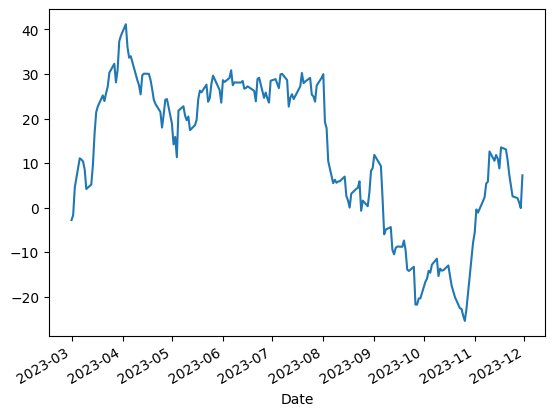

In [32]:
data['strategy'].plot()

In [59]:
class MomentumStrategy:
    def __init__(self, data, lookback_period=60, long_momentum = 0, short_momentum = 0):
        self.data = data.copy()
        self.lookback_period = lookback_period
        self.long_momentum = long_momentum
        self.short_momentum = short_momentum
        self.generate_strategy_column()
    
    def generate_strategy_column(self):
        self.data['close_shifted'] = self.data['close'].shift(self.lookback_period)
        self.data['strategy'] = self.data['close'] - self.data['close_shifted']
        self.data.dropna(axis=0, inplace=True)
        return self.data
    
    def generate_signals(self):
        signals = []
        trade_dict = {}
        prev_momentum = 0
        open_position = False
        
        for i in range(0, self.data.shape[0]):
            index = self.data.index[i]
            momentum = self.data.loc[index, 'strategy']
            if open_position == False:
                if momentum > self.long_momentum and prev_momentum <= self.long_momentum:
                    trade_dict["action"] = 'long'
                    trade_dict["open_date"] = index
                    open_position = True
                elif momentum < self.short_momentum and prev_momentum >= self.short_momentum:
                    trade_dict["action"] = 'short'
                    trade_dict["open_date"] = index
                    open_position = True
            else:
                if trade_dict["action"] == 'long' and momentum < self.long_momentum and prev_momentum >= self.long_momentum:
                    trade_dict["close_date"] = index
                    signals.append(trade_dict)
                    trade_dict = {}
                    open_position = False
                elif trade_dict["action"] == 'short' and momentum > self.short_momentum and prev_momentum <= self.short_momentum:
                    trade_dict["close_date"] = index
                    signals.append(trade_dict)
                    trade_dict = {}
                    open_position = False
            prev_momentum = momentum
        return signals

In [66]:
strat = MomentumStrategy(data, long_momentum=2, short_momentum=-2)

In [67]:
signals = strat.generate_signals()

In [68]:
signals

[{'action': 'short',
  'open_date': Timestamp('2023-03-01 00:00:00'),
  'close_date': Timestamp('2023-03-02 00:00:00')},
 {'action': 'long',
  'open_date': Timestamp('2023-03-03 00:00:00'),
  'close_date': Timestamp('2023-08-16 00:00:00')},
 {'action': 'long',
  'open_date': Timestamp('2023-08-18 00:00:00'),
  'close_date': Timestamp('2023-08-24 00:00:00')},
 {'action': 'long',
  'open_date': Timestamp('2023-08-29 00:00:00'),
  'close_date': Timestamp('2023-09-07 00:00:00')},
 {'action': 'long',
  'open_date': Timestamp('2023-11-07 00:00:00'),
  'close_date': Timestamp('2023-11-28 00:00:00')}]